# Example 4: Inverse estimation of soil hydraulic properties using Phydrus and MCMC 
*Authors: M. Vremec & R.A. Collenteur*

---
This notebook is part of a manuscript that is currently being prepared (spring 2020): 

*R.A. Collenteur, et. al. (in preparation) Phydrus: a Python implementation of the Hydrus-1D model.*

---
In this Notebook the model constructed in the previous example is extended for inverse estimation of soil hydrauilic properties 

1. generation of Synthethic Data by Forward Simulation 
2. inverse estimation of soil hydraulic properties using cumulative outflow, profile-averaged water content and matric head data in the objective function
---
In this notebook it is shown how the MCMC-algorithm can be used to estimate the soil hydrauilic properties for a Phydrus model. Apart from Phydrus being installed, the following Python Packages have to be installed:

- [emcee](https://emcee.readthedocs.io/en/stable/user/faq/)
- [lmfit](https://lmfit.github.io/lmfit-py/)
- [corner](https://corner.readthedocs.io)

### 1. Import the Pydrus package

In [263]:
# Import the necessary modules
import os

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import phydrus as ps
import corner
import lmfit

### 2. Generation of Synthethic Data by Forward Simulation
In the following code block we recreate the model developed in Example 1. We add solute transport to the model to calculate the water ages.

In [267]:
#Folder where the Hydrus files are to be stored
ws = "output"
exe = os.path.join(os.getcwd(), "../../hydrus.exe")

# Create model
ml = ps.Model(exe_name=exe, ws_name=ws, name="model",
              mass_units="mmol", time_unit="days", length_unit="cm")

ml.add_time_info(tinit=0, tmax=730, dtmin=1e-3, print_times=True);
ml.add_waterflow(top_bc=3, bot_bc=4)
ml.time_info["lPrint"] = False
# Add materials
m = ml.get_empty_material_df(n=1)
m.loc[[1]] = [[0.0, 0.3579, 0.0145, 1.5234, 50, 0.5]]
ml.add_material(m)

# Define loop for potential root water uptake distribution proposed by Hoffman and Van Genuchten
def z_loop(z, r1=10, r2=20):
    if z > -r1:
        return 1
    elif z < -(r1 + r2):
        return 0
    else:
        return(z + (r1 + r2)) / r2

bottom = -100  # Depth of the soil column
nodes = 150  # Dictretize into n nodes
ihead = -500  # Determine initial pressure head

profile = ps.create_profile(bot=bottom, dx=1, h=ihead, mat=1)
profile["Beta"] = profile.apply(lambda row: z_loop(row["x"]), axis=1)
ml.add_profile(profile)

ml.add_root_uptake(model=0, crootmax=100, omegac=0, p2h=-1500, p2l=-1500, poptm=[-25])

ml.add_obs_nodes([-30])

atm = pd.read_csv("../data/atmosphere.csv", index_col=0)
ml.add_atmospheric_bc(atm, hcrits=0)

# Write the input and check if the model simulates
ml.write_input()
ml.simulate();

Time to write the input files:

In [265]:
%%timeit
ml.write_input()

62.2 ms ± 2.59 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Time to execute Hydrus-1D:

In [266]:
%%timeit
ml.simulate()

595 ms ± 25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 3. Plot the seepage, averaged water content and matric potential over time

In [170]:
# extract cumulative outflow, averaged SWC, matric head at 30 cm
cum_bottom = ml.read_tlevel()["sum(vBot)"]
volume = ml.read_tlevel()["Volume"]
m_head = ml.read_obs_node()[31]["h"]

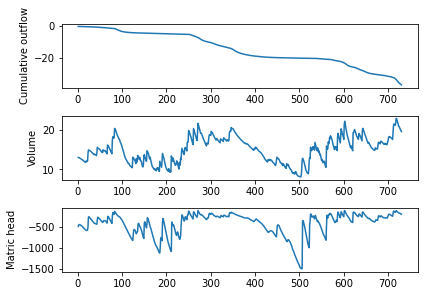

In [171]:
# plot
fix,ax=plt.subplots(nrows=3)
ax[0].plot(cum_bottom)
ax[0].set_ylabel("Cumulative outflow")
ax[1].plot(volume)
ax[1].set_ylabel("Volume")
ax[2].plot(m_head)
ax[2].set_ylabel("Matric head")
plt.tight_layout()

### 4. Use lmfit least squares (Marquedt-Levenberg) method to estimate initial conditions

In [269]:
# define function to execute Hydrus and compute residuals
def residual(pars, data=None):
    params = pars.valuesdict()
    ks=params["ks"]
    n=params["n"]
    alfa = params["Alfa"]
    ths=params["ths"]
    m = ml.get_empty_material_df(n=1)
    m.loc[[1]] = [[0.0, ths, alfa, n, ks, 0.5]]
    ml.add_material(m)
    ml.write_input()
    ml.simulate()

    sum_seep=np.asarray(ml.read_tlevel()["sum(vBot)"])
    volume = ml.read_tlevel()["Volume"]
    
    if len(sum_seep)<(len(data)/2):
        print("Hydrus-1D model did not converge under the next given parameters:", ths, alfa, n, ks)
        return data
    else:
        of = np.concatenate([np.asarray(sum_seep), np.asarray(volume)])
        residual = of-data
        return np.asarray(residual)

In [271]:
# Determine initial, lower and upper boundaries of soil hydraulic properties for the inverse parameter optimization strategies
params = lmfit.Parameters()
params.add("ths", value=0.39, min=0.3, max=0.52)  # Sandy Clay Loam - soil catalog
params.add("Alfa", value=0.059, min=0.006, max=0.22)
params.add("n", value=1.48, min=1.2, max=1.7)
params.add("ks", value=31, min=15, max=1000)
out = lmfit.minimize(residual, params,
                kws={'data': np.asarray(np.concatenate([np.asarray(cum_bottom), np.asarray(volume)]))},method="leastsq", epsfcn=1e-6)
out

In [272]:
# extract bottom flux, volume, matric head
cum_bottom1 = ml.read_tlevel()["sum(vBot)"]
volume1 = ml.read_tlevel()["Volume"]
m_head1 = ml.read_obs_node()[31]["h"]

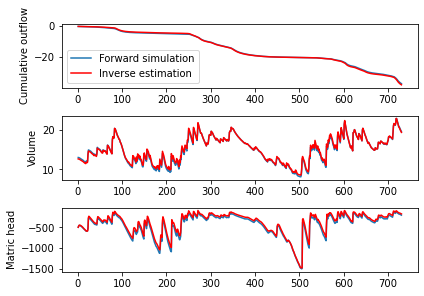

In [274]:
# plot
fix,ax=plt.subplots(nrows=3)
ax[0].plot(cum_bottom, label="Forward simulation")
ax[0].plot(cum_bottom1, color="red", label="Inverse estimation")
ax[0].set_ylabel("Cumulative outflow")
ax[1].plot(volume)
ax[1].plot(volume1, color="red")
ax[1].set_ylabel("Volume")
ax[2].plot(m_head)
ax[2].plot(m_head1, color="red")
ax[2].set_ylabel("Matric head")
ax[0].legend()
plt.tight_layout()

### 5. Use EMCEE for inverse estimation

In [183]:
# Determine initial, lower and upper boundaries of soil hydraulic properties for the inverse parameter optimization strategies
params = lmfit.Parameters()
params.add("ths", value=out.params["ths"].value, min=0.3, max=0.52)
params.add("Alfa", value=out.params["Alfa"].value, min=0.006, max=0.22)
params.add("n", value=out.params["n"].value, min=1.2, max=1.7)
params.add("ks", value=out.params["ks"].value, min=15, max=1000)
out_emcee = lmfit.minimize(residual, params, kws={'data': np.asarray(np.concatenate([np.asarray(cum_bottom), np.asarray(volume)]))},
                     method="emcee", steps=200, burn=10, thin=5, is_weighted=True)
out_emcee

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [4:10:37<00:00, 75.19s/it]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [25.11575018 23.32716557 26.07483055 21.54389042]


In [189]:
out_emcee

In [282]:
cum_bottom2 = ml.read_tlevel()["sum(vBot)"]
volume2 = ml.read_tlevel()["Volume"]
m_head2 = ml.read_obs_node()[31]["h"]

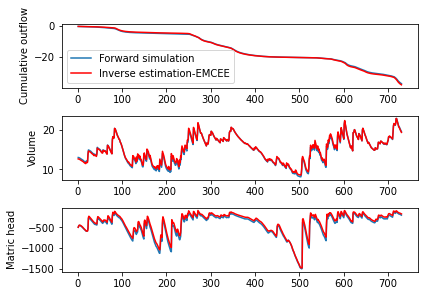

In [283]:
# plot
fix,ax=plt.subplots(nrows=3)
ax[0].plot(cum_bottom, label="Forward simulation")
ax[0].plot(cum_bottom2, color="red", label="Inverse estimation-EMCEE")
ax[0].set_ylabel("Cumulative outflow")
ax[1].plot(volume)
ax[1].plot(volume2, color="red")
ax[1].set_ylabel("Volume")
ax[2].plot(m_head)
ax[2].plot(m_head2, color="red")
ax[2].set_ylabel("Matric head")
ax[0].legend()
plt.tight_layout()

In [281]:
# functions to save and import lmfit.minimizer results
def save_minimizer(minimizerresult, filename):
    """minimizerresult: MinimizerResult object"""
    with open(filename, 'w') as fp:
        fp.write(str(minimizerresult.var_names) + "\n" + (str(list(minimizerresult.params.valuesdict().values()))+ "\n"))
    minimizerresult.flatchain.to_csv(filename, mode='a', sep=";")
def import_minimizer(filename):
    """minimizerresult: MinimizerResult object"""
    f=open(filename)
    lines=f.readlines()
    labels = lines[0]
    truths = lines[1]
    df = pd.read_csv(filename, skiprows=2, index_col=0, sep=";")
    return df, labels, truths

## 6. Visualize the results
The results are a Pandas DataFrame with $n$ the parameter samples, whgere $n$ is calculated as follows:

$n = \frac{(\text{steps}-\text{burn})\cdot\text{nwalkers}}{\text{thin}} $

## Corner.py
Corner is a simple but great python package that makes creating corner graphs easy. One line of code suffices to create a plot of the parameter distributions and the covariances between the parameters. 

In [279]:
# save/import minimizer results
#save_minimizer(out, "emcee_example1.csv")
df_out, labels, truths = import_minimizer("emcee_example.csv")

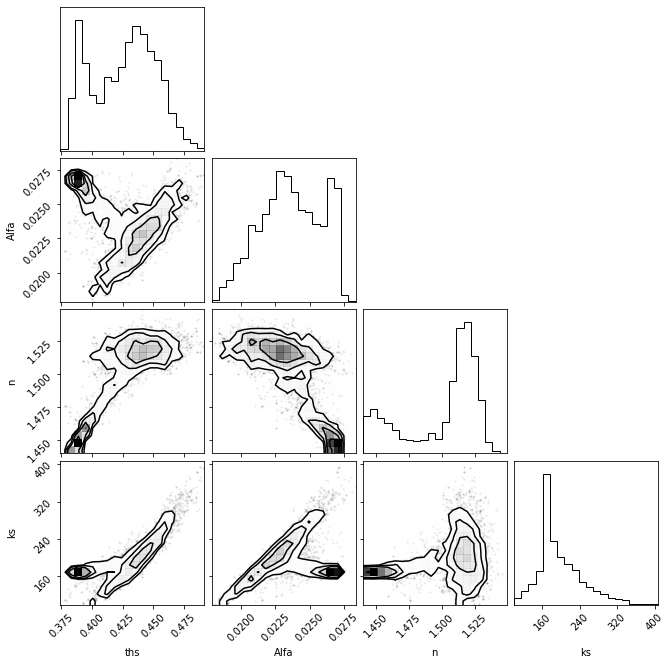

In [280]:
import corner
emcee_corner = corner.corner(df_out, truths=truths)

## 7. What happens to the walkers at each step?
The walkers take steps in different directions for each step. It is expected that after a number of steps, the direction of the step becomes random, as a sign that an optimum has been found. This can be checked by looking at the autocorrelation, which should be insignificant after a number of steps (NOT SURE HOW TO INTERPRET THIS YET). However it does not seem the case that the parameters converge to come optimum yet, even for the simple Linear model (from Collenteur, Pastas - example EMCEE Hammer).

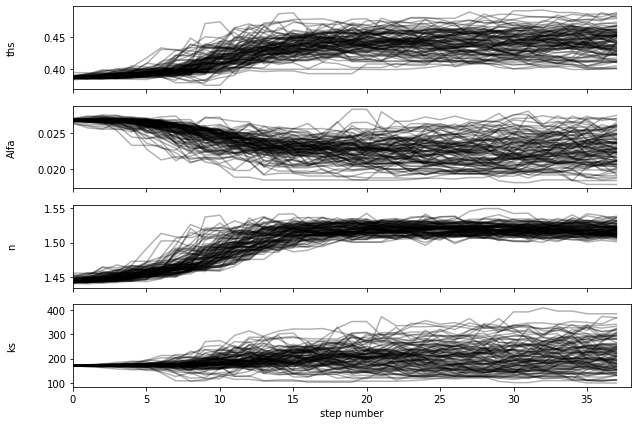

In [284]:
labels = df_out.columns

fig, axes = plt.subplots(labels.size, figsize=(10, 7), sharex=True)
samples = np.asarray(df_out).reshape(int(len(df_out)/100),100,len(df_out.columns))
for i in range(labels.size):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

### 8. Plot some simulated time series to display uncertainty?

Text(0, 0.5, 'Volume')

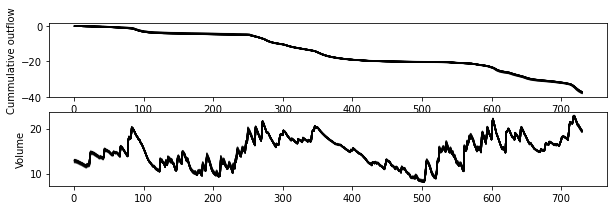

In [286]:
fig,ax = plt.subplots(nrows=2, figsize=(10,3))

inds = np.random.randint(len(df_out), size=100)
for ind in inds:
    params = df_out.iloc[ind].values
    m = ml.get_empty_material_df(n=1)
    m.loc[[1]] = [[0.0, params[0], params[1], params[2], params[3], 0.5]]
    ml.add_material(m)
    ml.write_input()
    ml.simulate()
    ax[0].plot(ml.read_tlevel()["sum(vBot)"], c="k", alpha=0.1)
    ax[1].plot(ml.read_tlevel()["Volume"], c="k", alpha=0.1)
ax[0].set_ylabel("Cummulative outflow")
ax[1].set_ylabel("Volume")